In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import collections
import re
import nltk
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn import feature_extraction,feature_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn import pipeline
## for sentiment
from textblob import TextBlob
## for embedding types
import spacy
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [38]:
df = pd.read_csv('news.csv')

In [3]:
df.shape

(6335, 4)

In [4]:
df.head(10)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL


In [39]:
df.drop('Unnamed: 0',inplace=True,axis=1) 

In [ ]:
# print("--- cleaning ---")
# txt = re.sub(r'[^\w\s]', '', str(df['title'][0]).lower().strip())
# print(txt)
# print("--- tokenization ---")
# txt = txt.split()
# print(txt)
# print("--- stemming ---")
# ps = nltk.stem.porter.PorterStemmer()
# print([ps.stem(word) for word in txt])print("--- lemmatisation ---")
# lem = nltk.stem.wordnet.WordNetLemmatizer()
# print([lem.lemmatize(word) for word in txt])

In [41]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [15]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dragox.RS\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [50]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dragox.RS\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [43]:
#Feature_Eng
df['title'] = df['title'].apply(lambda x:  utils_preprocess_text(x))

df['text'] = df['text'].apply(lambda x:  utils_preprocess_text(x))

#0=FAKE 1=REAL
df['label'] = df['label'].apply(lambda x:   x.replace('FAKE','0'))
df['label'] = df['label'].apply(lambda x:   x.replace('REAL','1'))

In [46]:
df['label'] = pd.to_numeric(df['label'])

In [47]:
df.head()

,title,text,label
0,you can smell hillary fear,daniel greenfield a shillman journalism fellow...,0
1,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,0
2,kerry to go to paris in gesture of sympathy,u secretary of state john f kerry said monday ...,1
3,bernie supporter on twitter erupt in anger aga...,kaydee king kaydeeking november 9 2016 the les...,0
4,the battle of new york why this primary matter,it primary day in new york and frontrunners hi...,1


In [48]:
df.dtypes

title    object
text     object
label     int64
dtype: object

In [49]:
df['label'].describe()

count    6335.000000
mean        0.500552
std         0.500039
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: label, dtype: float64

In [60]:
df.loc[lambda df: df['word_count'] == 0].count()

title         36
text          36
label         36
word_count    36
char_count    36
dtype: int64

In [73]:
df= df[df['word_count'] != 0]

In [74]:
df.loc[lambda df: df['word_count'] == 0].count()

title         0
text          0
label         0
word_count    0
char_count    0
dtype: int64

In [75]:
#word_count_column
df['word_count'] = df["text"].apply(lambda x: len(str(x).split(" ")))

#char_count_column
df['char_count'] = df["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))

#avg_word_column
df['avg_word'] = df['char_count'] / df['word_count']

In [76]:
df.head()

,title,text,label,word_count,char_count,avg_word
0,you can smell hillary fear,daniel greenfield a shillman journalism fellow...,0,1296,5929,4.574846
1,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,0,441,2087,4.732426
2,kerry to go to paris in gesture of sympathy,u secretary of state john f kerry said monday ...,1,431,2005,4.651972
3,bernie supporter on twitter erupt in anger aga...,kaydee king kaydeeking november 9 2016 the les...,0,399,2106,5.278195
4,the battle of new york why this primary matter,it primary day in new york and frontrunners hi...,1,317,1410,4.447950


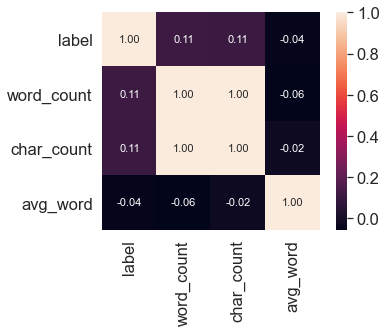

In [84]:
k = 6 #number of variables for heatmap
corrmat = df.corr()
cols = corrmat.nlargest(k, 'label')['label'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 11}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

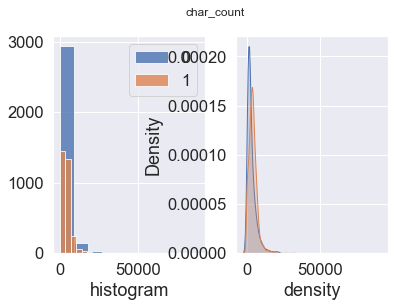

In [92]:
x, y = "char_count", "label"
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(x, fontsize=12)
for i in df[y].unique():
    sns.distplot(df[df[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(df[df[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(df[y].unique())
ax[1].grid(True)
plt.show()

In [97]:
df["sentiment_text"] = df['text'].apply(lambda x: 
                   TextBlob(x).sentiment.polarity)

In [98]:
df["sentiment_title"] = df['title'].apply(lambda x: 
                   TextBlob(x).sentiment.polarity)

In [99]:
df.head(10)

,title,text,label,word_count,char_count,avg_word,sentiment_text,sentiment_title
0,you can smell hillary fear,daniel greenfield a shillman journalism fellow...,0,1296,5929,4.574846,0.050697,0.000000
1,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,0,441,2087,4.732426,0.027814,0.125000
2,kerry to go to paris in gesture of sympathy,u secretary of state john f kerry said monday ...,1,431,2005,4.651972,0.102574,0.000000
3,bernie supporter on twitter erupt in anger aga...,kaydee king kaydeeking november 9 2016 the les...,0,399,2106,5.278195,0.071158,-0.700000
4,the battle of new york why this primary matter,it primary day in new york and frontrunners hi...,1,317,1410,4.447950,0.248086,0.268182
5,tehran usa,im not an immigrant but my grandparent are mor...,0,2332,10353,4.439537,0.071187,0.000000
6,girl horrified at what she watch boyfriend do ...,share this baylee luciani left screenshot of w...,0,552,2479,4.490942,0.062398,0.000000
7,britain schindler dy at 106,a czech stockbroker who saved more than 650 je...,1,123,622,5.056911,0.034375,0.000000
8,fact check trump and clinton at the commanderi...,hillary clinton and donald trump made some ina...,1,2342,10753,4.591375,0.007563,0.000000
9,iran reportedly make new push for uranium conc...,iranian negotiator reportedly have made a last...,1,708,3371,4.761299,0.038974,0.136364


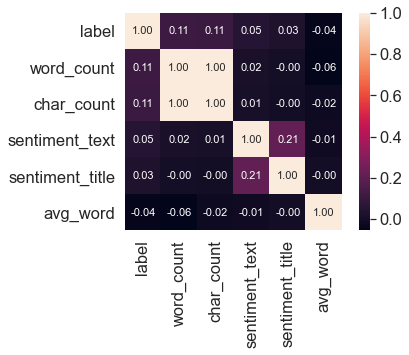

In [100]:
k = 8 #number of variables for heatmap
corrmat = df.corr()
cols = corrmat.nlargest(k, 'label')['label'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 11}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [105]:
## call model
ner = spacy.load("en_core_web_md")

In [107]:
## tag text and exctract tags into a list
df["tags"] = df["text"].apply(lambda x: [(tag.text, tag.label_) 
                                for tag in ner(x).ents] )## utils function to count the element of a list
def utils_lst_count(lst):
    dic_counter = collections.Counter()
    for x in lst:
        dic_counter[x] += 1
    dic_counter = collections.OrderedDict( 
                     sorted(dic_counter.items(), 
                     key=lambda x: x[1], reverse=True))
    lst_count = [ {key:value} for key,value in dic_counter.items() ]
    return lst_count
## count tags
df["tags"] = df["tags"].apply(lambda x: utils_lst_count(x))
## utils function create new column for each tag category
def utils_ner_features(lst_dics_tuples, tag):
    if len(lst_dics_tuples) > 0:
        tag_type = []
        for dic_tuples in lst_dics_tuples:
            for tuple in dic_tuples:
                type, n = tuple[1], dic_tuples[tuple]
                tag_type = tag_type + [type]*n
                dic_counter = collections.Counter()
                for x in tag_type:
                    dic_counter[x] += 1
        return dic_counter[tag]
    else:
        return 0
## extract features
tags_set = []
for lst in df["tags"].tolist():
     for dic in lst:
          for k in dic.keys():
              tags_set.append(k[1])
tags_set = list(set(tags_set))
for feature in tags_set:
     df["text_tags_"+feature] = df["tags"].apply(lambda x: 
                             utils_ner_features(x, feature))
## print result
df.head()

,title,text,label,word_count,char_count,avg_word,sentiment_text,sentiment_title,tags,text_tags_CARDINAL,...,text_tags_EVENT,text_tags_FAC,text_tags_LANGUAGE,text_tags_PERSON,text_tags_LAW,text_tags_ORDINAL,text_tags_WORK_OF_ART,text_tags_LOC,text_tags_QUANTITY,text_tags_PRODUCT
0,you can smell hillary fear,daniel greenfield a shillman journalism fellow...,0,1296,5929,4.574846,0.050697,0.000000,"[{('hillary clinton', 'PERSON'): 7}, {('clinto...",4,...,0,0,0,17,0,1,0,0,0,0
1,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,0,441,2087,4.732426,0.027814,0.125000,"[{('two', 'CARDINAL'): 1}, {('today', 'DATE'):...",2,...,0,0,0,0,0,0,0,0,0,1
2,kerry to go to paris in gesture of sympathy,u secretary of state john f kerry said monday ...,1,431,2005,4.651972,0.102574,0.000000,"[{('france', 'GPE'): 5}, {('american', 'NORP')...",2,...,0,0,0,2,0,0,0,0,0,0
3,bernie supporter on twitter erupt in anger aga...,kaydee king kaydeeking november 9 2016 the les...,0,399,2106,5.278195,0.071158,-0.700000,"[{('november 9 2016', 'DATE'): 5}, {('democrat...",6,...,0,0,0,6,0,0,0,0,0,0
4,the battle of new york why this primary matter,it primary day in new york and frontrunners hi...,1,317,1410,4.447950,0.248086,0.268182,"[{('republican', 'NORP'): 2}, {('clinton', 'PE...",6,...,0,0,0,3,0,0,0,0,0,0


In [110]:
## tag title and exctract tags into a list
df["tags"] = df["title"].apply(lambda x: [(tag.text, tag.label_) 
                                for tag in ner(x).ents] )## utils function to count the element of a list
def utils_lst_count(lst):
    dic_counter = collections.Counter()
    for x in lst:
        dic_counter[x] += 1
    dic_counter = collections.OrderedDict( 
                     sorted(dic_counter.items(), 
                     key=lambda x: x[1], reverse=True))
    lst_count = [ {key:value} for key,value in dic_counter.items() ]
    return lst_count
## count tags
df["tags"] = df["tags"].apply(lambda x: utils_lst_count(x))
## utils function create new column for each tag category
def utils_ner_features(lst_dics_tuples, tag):
    if len(lst_dics_tuples) > 0:
        tag_type = []
        for dic_tuples in lst_dics_tuples:
            for tuple in dic_tuples:
                type, n = tuple[1], dic_tuples[tuple]
                tag_type = tag_type + [type]*n
                dic_counter = collections.Counter()
                for x in tag_type:
                    dic_counter[x] += 1
        return dic_counter[tag]
    else:
        return 0
## extract features
tags_set = []
for lst in df["tags"].tolist():
     for dic in lst:
          for k in dic.keys():
              tags_set.append(k[1])
tags_set = list(set(tags_set))
for feature in tags_set:
     df["title_tags_"+feature] = df["tags"].apply(lambda x: 
                             utils_ner_features(x, feature))
## print result
df.head()

,title,text,label,word_count,char_count,avg_word,sentiment_text,sentiment_title,tags,text_tags_CARDINAL,...,title_tags_DATE,title_tags_TIME,title_tags_MONEY,title_tags_FAC,title_tags_PERSON,title_tags_LAW,title_tags_ORDINAL,title_tags_LOC,title_tags_QUANTITY,title_tags_PRODUCT
0,you can smell hillary fear,daniel greenfield a shillman journalism fellow...,0,1296,5929,4.574846,0.050697,0.000000,[],4,...,0,0,0,0,0,0,0,0,0,0
1,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,0,441,2087,4.732426,0.027814,0.125000,[],2,...,0,0,0,0,0,0,0,0,0,0
2,kerry to go to paris in gesture of sympathy,u secretary of state john f kerry said monday ...,1,431,2005,4.651972,0.102574,0.000000,[],2,...,0,0,0,0,0,0,0,0,0,0
3,bernie supporter on twitter erupt in anger aga...,kaydee king kaydeeking november 9 2016 the les...,0,399,2106,5.278195,0.071158,-0.700000,[],6,...,0,0,0,0,0,0,0,0,0,0
4,the battle of new york why this primary matter,it primary day in new york and frontrunners hi...,1,317,1410,4.447950,0.248086,0.268182,[],6,...,0,0,0,0,0,0,0,0,0,0


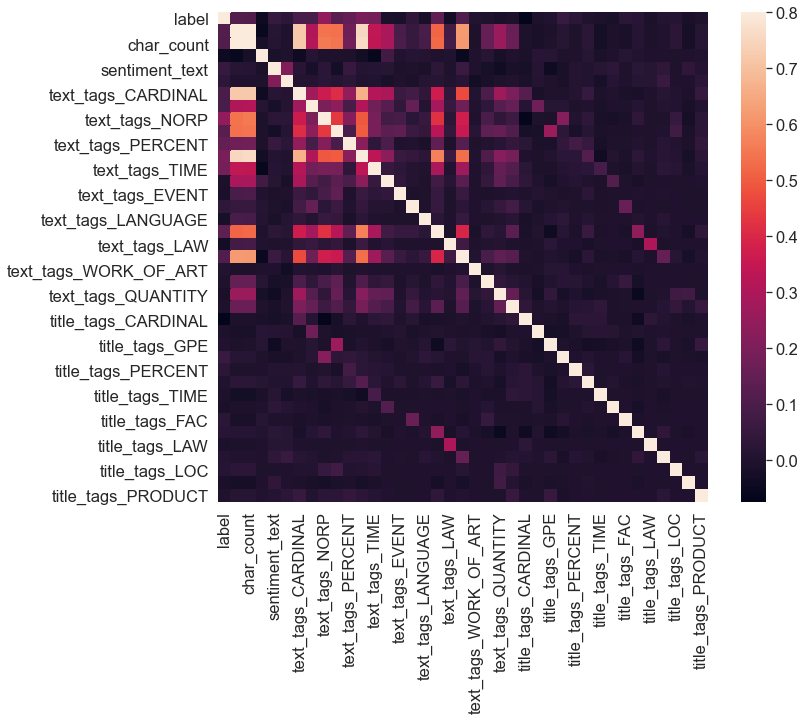

In [112]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [180]:
df.to_csv('out.csv')

In [168]:
## Count (classic BoW)
vectorizer_text = feature_extraction.text.CountVectorizer(analyzer='word',max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer_text = feature_extraction.text.TfidfVectorizer(analyzer='word',max_features=10000, ngram_range=(1,2))

In [169]:
corpus = df["text"]
vectorizer_text.fit(corpus)
X_train = vectorizer_text.transform(corpus)
dic_vocabulary_text = vectorizer_text.vocabulary_

In [170]:
y = df["label"]
X_names = vectorizer_text.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [171]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# 0:
  . selected features: 430
  . top features: cruz,said,republican,sander,he,rubio,delegate,october,gop,bush
 
# 1:
  . selected features: 430
  . top features: cruz,said,republican,sander,he,rubio,delegate,october,gop,bush
 


In [172]:
vectorizer_title = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer_title.fit(corpus)
X_train = vectorizer_title.transform(corpus)
dic_vocabulary_title = vectorizer_title.vocabulary_

In [173]:
## Count (classic BoW)
vectorizer_title = feature_extraction.text.CountVectorizer(analyzer='word',max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer_title = feature_extraction.text.TfidfVectorizer(analyzer='word',max_features=10000, ngram_range=(1,2))

In [176]:
corpus = df["title"]
vectorizer_title.fit(corpus)
X_train = vectorizer_title.transform(corpus)
dic_vocabulary_title = vectorizer_title.vocabulary_

In [177]:
y = df["label"]
X_names = vectorizer_title.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [178]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# 0:
  . selected features: 172
  . top features: gop,sander,debate,cruz,obama,republican,comment on,iran,house,russia
 
# 1:
  . selected features: 172
  . top features: gop,sander,debate,cruz,obama,republican,comment on,iran,house,russia
 


In [179]:
vectorizer_title = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer_title.fit(corpus)
X_train = vectorizer_text.transform(corpus)
dic_vocabulary = vectorizer_title.vocabulary_

In [188]:
#Loading Dataset

train = pd.read_csv("out.csv")


X = train[:train.shape[0]]
del X['label']
del X['text']
del X['title']

y = train.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)


In [189]:
classifier = PassiveAggressiveClassifier(max_iter=50)

## pipeline
model = pipeline.Pipeline([("vectorizer_text", vectorizer_text),
                           ('vectorizer_title',vectorizer_title),
                           ("classifier", classifier)])## train classifier
model["classifier"].fit(X_train, y_train)## test
X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

ValueError: could not convert string to float: '[]'

In [116]:
#DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7)
#DataFlair - Fit and transform train set, transform test set
tfidf_train=tfidf_vectorizer.fit_transform(X_train) 
tfidf_test=tfidf_vectorizer.transform(X_test)

In [117]:
#DataFlair - Initialize a PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)
#DataFlair - Predict on the test set and calculate accuracy
y_pred=pac.predict(tfidf_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

ValueError: Found input variables with inconsistent numbers of samples: [21, 4244]


    Logistic Regression
    k-Nearest Neighbors
    Decision Trees
    Support Vector Machine
    Naive Bayes
